In [1]:
import torch
# gpu 사용 가능 여부 확인
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: NVIDIA GeForce GTX 1050 Ti


device(type='cuda')

In [2]:
import torch
import torch.nn as nn
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape) # *매개변수 : tuple

In [3]:
import pandas as pd
# 생성 모델
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218,178,3))
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [5]:
G=torch.load('d:/data/model/final_celeba_G.h5')
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
)

In [6]:
#학습된 가중치 확인
print(G.model[3].weight[0][:10])
print(G.model[3].bias[:10])

tensor([-0.0011,  0.0013, -0.0390,  0.0242, -0.0175, -0.0003, -0.0848,  0.0461,
         0.0045, -0.0522], grad_fn=<SliceBackward0>)
tensor([-0.0282,  0.0070, -0.0211,  0.0331, -0.0078,  0.0068, -0.0431, -0.0370,
         0.0215, -0.0427], grad_fn=<SliceBackward0>)


In [7]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

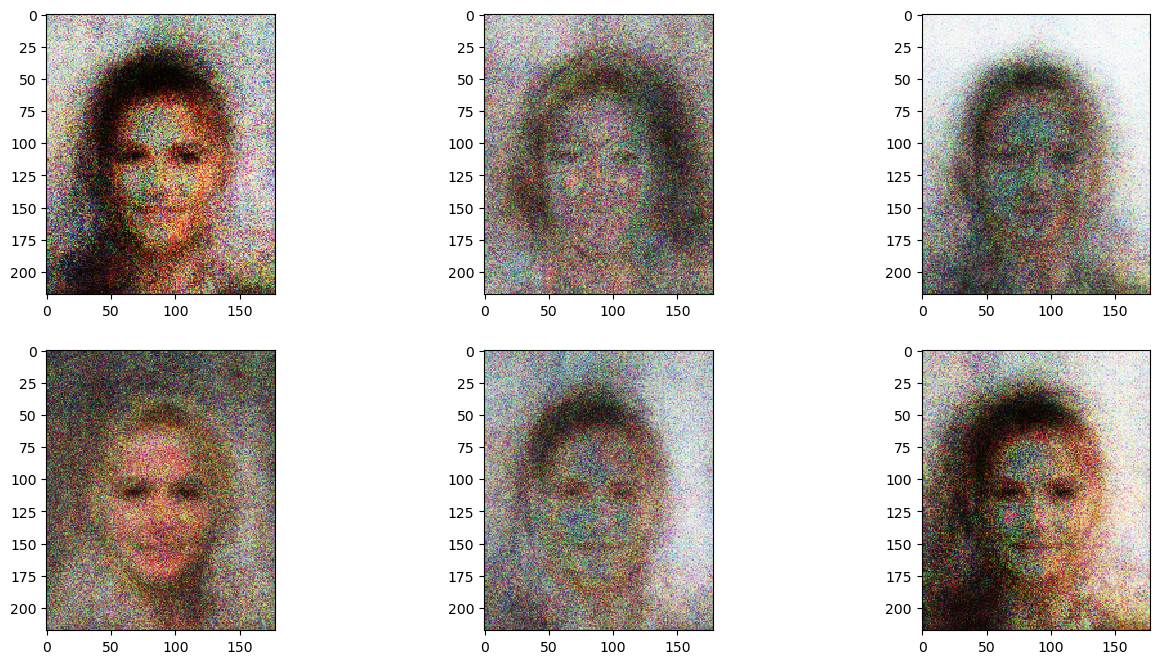

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
count = 0
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [9]:
# GPU 메모리 사용량
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.4026060104370117

In [10]:
# 실행중 최대 메모리 사용량
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.40347957611083984

In [11]:
# 메모리 사용량 통계
# abbreviated 요약 여부
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 422163 KiB | 423079 KiB | 427220 KiB |   5057 KiB |
|---------------------------------------------------------------------------|
| Active memory         | 422163 KiB | 423079 KiB | 427220 KiB |   5057 KiB |
|---------------------------------------------------------------------------|
| Requested memory      | 419765 KiB | 420679 KiB | 424789 KiB |   5023 KiB |
|---------------------------------------------------------------